In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed
import pandas as pd
import random
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from types import SimpleNamespace
import io
import matplotlib.gridspec as gridspec
import corner

from led_off_gamma_omega_pdf_utils import (
    cum_pro_and_reactive_time_vary_fn, 
    up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_time_varying_led_off_fn,
    rho_A_t_VEC_fn,
    up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn,
    phi_t_fn
)

from single_cond_utils import PA_with_LEDON_2_VEC

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')



# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')


len of LED off: 66226
len of led off valid trials = 53472
len of valid trials < 1s : 52799


In [3]:
# w median = 0.5359773939178702
# bump width median = 0.24090610767674503
# dip width median = 0.038433784998534365
# dip height median =  0.32760753426495454

In [4]:
## VBMC params
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 

# other params
K_max = 10

# LED Off - no noise
noise = 0

# phi params
bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

# starting pt
w = 0.535

In [5]:
def compute_loglike_trial(row, gamma, omega, t_E_aff, w, bump_width, bump_height, dip_width, dip_height):
    phi_params =  {
    'h1': bump_width,
    'a1': bump_height,
    'b1': bump_offset,
    'h2': dip_width,
    'a2': dip_height
    }
    phi_params_obj = SimpleNamespace(**phi_params)

    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']

    response_poke = row['response_poke']
    

    trunc_factor_p_joint = cum_pro_and_reactive_time_vary_fn(t_stim+1, V_A, theta_A, t_A_aff, gamma, omega, t_stim, t_E_aff, w, phi_params_obj) -\
                                cum_pro_and_reactive_time_vary_fn(t_stim, V_A, theta_A, t_A_aff, gamma, omega, t_stim, t_E_aff, w, phi_params_obj)
    
    bound_val = 2*response_poke - 5
    P_joint_rt_choice = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_time_varying_led_off_fn(rt, V_A, theta_A, gamma, omega, t_stim, \
                                            t_A_aff, t_E_aff, del_go, phi_params_obj, w, bound_val, K_max)
    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)


    return wt_log_like

In [6]:
omega_bounds = [0.05, 10]
omega_plausible_bounds = [0.5, 8]

t_E_aff_bounds = [0.035, 0.075]
t_E_aff_plausible_bounds = [0.04, 0.07]

bump_height_bounds = [0.02, 1]
bump_height_plausible_bounds = [0.1, 0.5]

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff, bump_height = params

    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    bump_height_logpdf = trapezoidal_logpdf(bump_height, bump_height_bounds[0], bump_height_plausible_bounds[0], bump_height_plausible_bounds[1], bump_height_bounds[1])

    return (
        gamma_logpdf +
        omega_logpdf +
        t_E_aff_logpdf +
        bump_height_logpdf
    )


++++++++++ ABL = 40, ILD = -2 +++++++++++++++++++++
Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -125.232 +/-0.004.


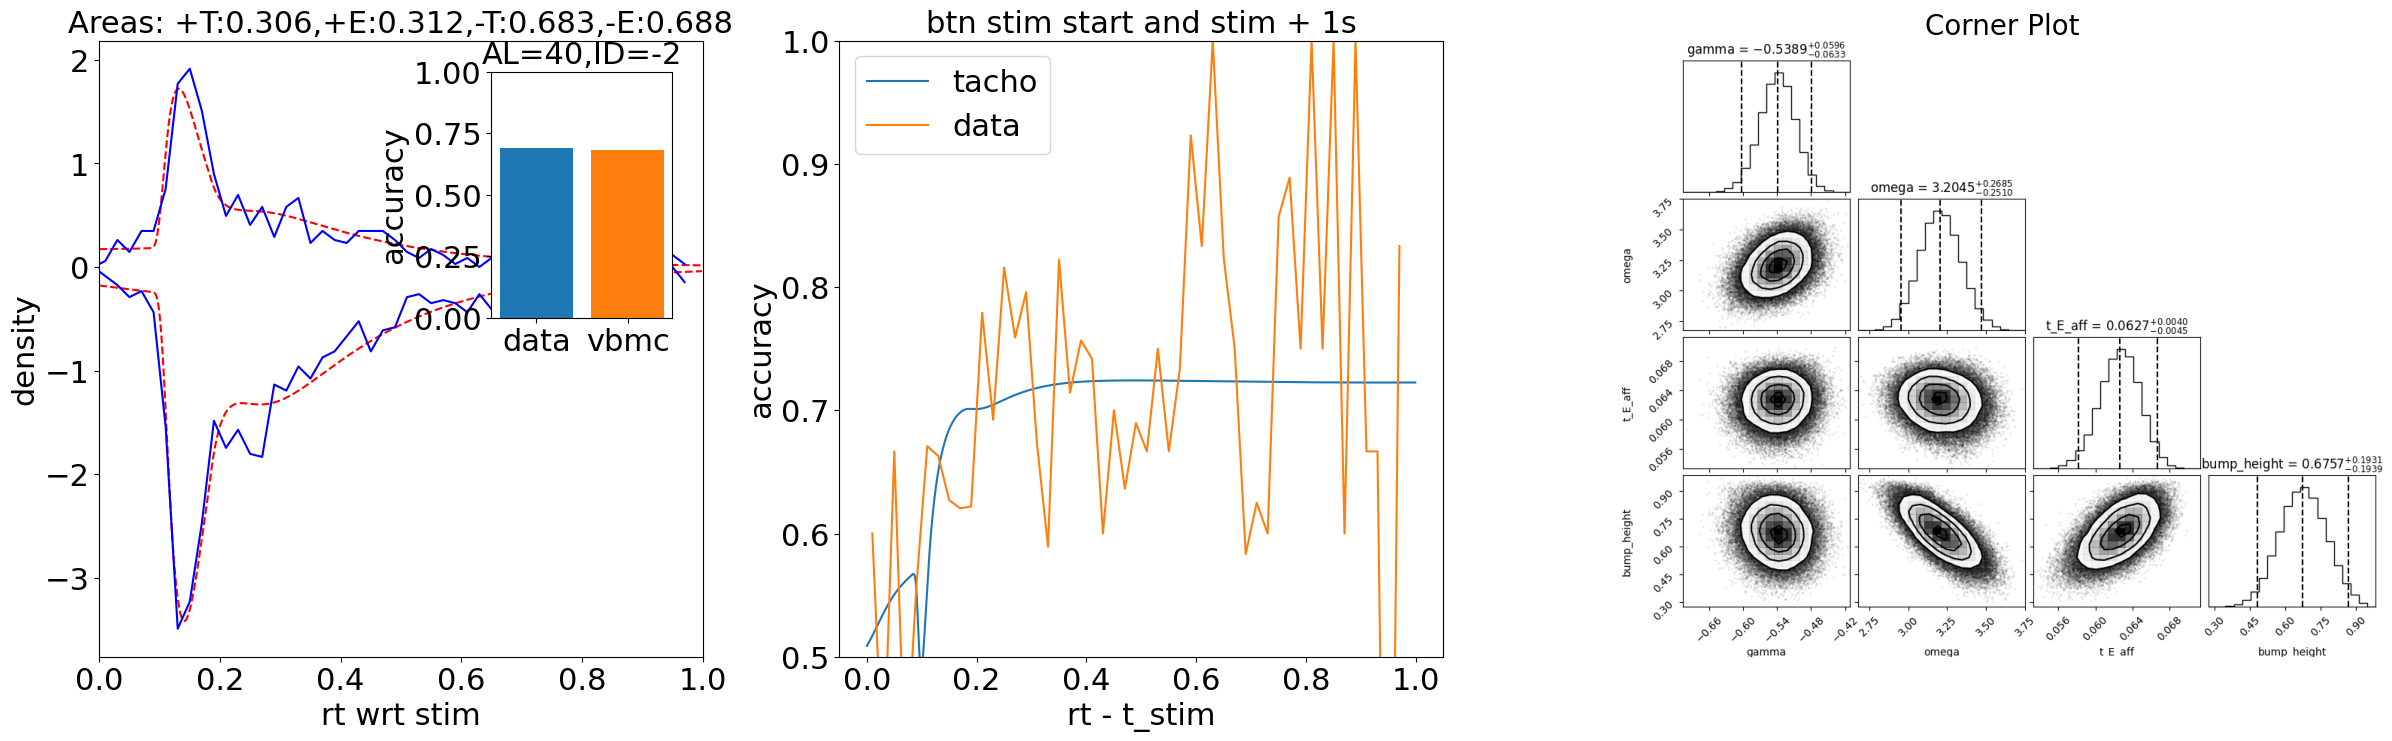

In [ ]:
all_ABLs_cond = [40]
all_ILDs_cond = [-2]
for cond_ABL in all_ABLs_cond:
    for cond_ILD in all_ILDs_cond:
        conditions = {'ABL': [cond_ABL], 'ILD': [cond_ILD]}

        # Applying the filter
        df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
            (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
            (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
        ]

        def vbmc_loglike_fn(params):
            gamma, omega, t_E_aff, bump_height = params

            all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff, w, \
                                                                            bump_width, bump_height, dip_width, dip_height) \
                                            for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
            
            return np.sum(all_loglike)
        
        def vbmc_joint_fn(params):
            priors = vbmc_prior_fn(params)
            loglike = vbmc_loglike_fn(params)

            return priors + loglike

        print(f'++++++++++ ABL = {cond_ABL}, ILD = {cond_ILD} +++++++++++++++++++++')
        if cond_ILD > 0:
            gamma_bounds = [0.001, 5]
            gamma_plausible_bounds = [0.09, 0.9]
        elif cond_ILD < 0:
            gamma_bounds = [-5, -0.001]
            gamma_plausible_bounds = [-0.9, -0.09]

        
        # Add bounds for all parameters
        lb = np.array([
            gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0], bump_height_bounds[0]
        ])
        ub = np.array([
            gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1], bump_height_bounds[1]
        ])

        plb = np.array([
            gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0], bump_height_plausible_bounds[0]
        ])
        pub = np.array([
            gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1], bump_height_plausible_bounds[1]
        ])

        # Initialize with random values within plausible bounds
        np.random.seed(42)
        gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
        omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
        t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
        bump_height_0 = np.random.uniform(bump_height_plausible_bounds[0], bump_height_plausible_bounds[1])

        x_0 = np.array([
            gamma_0, omega_0, t_E_aff_0, bump_height_0
        ])

        # Run VBMC
        vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
        vp, results = vbmc.optimize()

        vbmc.save(f'each_cond_data_apr/vbmc_T_vary_only_height_single_condn_ABL_{cond_ABL}_ILD_{cond_ILD}.pkl', overwrite=True)

        vp_samples = vp.sample(int(1e5))[0]

        # Extract samples for each parameter
        gamma_samples = vp_samples[:, 0]
        omega_samples = vp_samples[:, 1]
        t_E_aff_samples = vp_samples[:, 2]
        bump_height_samples = vp_samples[:, 3]

        # Compute mean estimates
        gamma = gamma_samples.mean()
        omega = omega_samples.mean()
        t_E_aff = t_E_aff_samples.mean()
        bump_height = bump_height_samples.mean()

        # Create array for corner plot
        corner_samples = np.vstack([
            gamma_samples, omega_samples, t_E_aff_samples, bump_height_samples
        ]).T

        # Compute ranges for plot
        percentiles = np.percentile(corner_samples, [0, 100], axis=0)
        _ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(corner_samples.shape[1])]

        # Labels for each parameter
        param_labels = [
            'gamma', 'omega', 't_E_aff', 'bump_height'
        ]

        # Generate corner plot
        fig_corner = corner.corner(
            corner_samples,
            labels=param_labels,
            show_titles=True,
            quantiles=[0.025, 0.5, 0.975],
            range=_ranges,
            title_fmt=".4f"
        );

        filename = f"corner_T_vary_only_height_each_cond_ABL_{cond_ABL}_ILD_{cond_ILD}.png"
        save_path = os.path.join("each_cond_data_apr", filename)
        fig_corner.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_corner)

        # Diagnostics
        df_led_off = df[df['LED_trial'] == 0]
        # < 1s RTs
        df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
        # remove truncated aborts
        data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
        # renaming
        data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
            columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
        )

        ### ABORTS + VALID TRIALS + ABL, ILD CONDITION
        data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
            (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
            (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
        ]

        data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

        # VALID TRIALS CONDITION
        df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
            (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
            (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
        ]

        ## Diag 1
        phi_params = {
            'h1': bump_width,
            'a1': bump_height,
            'h2': dip_width,
            'a2': dip_height,
            'b1': bump_offset
        }

        phi_params_obj = SimpleNamespace(**phi_params)

        N_theory = int(1e3)
        random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
        t_pts = np.arange(0, 1, 0.001)

        P_A_samples = np.zeros((N_theory, len(t_pts)))
        for idx in range(N_theory):
            t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
            pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)
            P_A_samples[idx, :] = pdf

        P_A_samples_mean = np.mean(P_A_samples, axis=0)
        C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)
        
        up_wrt_stim = np.zeros_like(t_pts)
        down_wrt_stim = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            
            up_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega,\
                                                                                              t_E_aff, del_go, phi_params_obj,\
                                                                                                  w, 1, K_max)
            
            down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega,\
                                                                                              t_E_aff, del_go, phi_params_obj,\
                                                                                                  w, -1, K_max)

        bins = np.arange(-1,1,0.02)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        ## data
        data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
        data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

        data_up_rt = data_up['rt'] - data_up['t_stim']
        data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

        data_down_rt = data_down['rt'] - data_down['t_stim']
        data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

        frac_up_data = len(data_up) / len(df_led_off_valid_trials_cond_filtered)
        frac_down_data = len(data_down) / len(df_led_off_valid_trials_cond_filtered)

        
        theory_area_up = trapz(up_wrt_stim, t_pts)
        theory_area_down = trapz(down_wrt_stim, t_pts)

        # accuracy
        xlabels = ['data', 'vbmc']
        if conditions['ILD'][0] > 0:
            accuracy_data_and_theory = [frac_up_data, theory_area_up]
        else:
            accuracy_data_and_theory = [frac_down_data, theory_area_down]

        # tacho = np.zeros_like(t_pts)
        # for idx, t in enumerate(t_pts):
        #     P_A = P_A_samples_mean[idx]
        #     C_A = C_A_mean[idx]
            
        #     P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, 1, K_max)
        #     P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, -1, K_max)
            
        #     if conditions['ILD'][0] > 0:
        #         P_rt_c = P_up
        #     else:
        #         P_rt_c = P_down
                
        #     P_rt = P_up + P_down
        #     tacho[idx] = P_rt_c / (P_rt + 1e-10)

        P_rt = up_wrt_stim + down_wrt_stim
        if conditions['ILD'][0] > 0:
            tacho = up_wrt_stim / (P_rt + 1e-10)
        else:
            tacho = down_wrt_stim / (P_rt + 1e-10)

        df_led_off_valid_trials_cond_filtered_copy = df_led_off_valid_trials_cond_filtered.copy()
        df_led_off_valid_trials_cond_filtered_copy.loc[:, 'RT_bin'] = pd.cut(df_led_off_valid_trials_cond_filtered_copy['rt'] - df_led_off_valid_trials_cond_filtered_copy['t_stim'],\
                                                                    bins = bins, include_lowest=True)
        grouped_by_rt_bin = df_led_off_valid_trials_cond_filtered_copy.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

        ### Plot ###
        FONT_SIZE_LABEL = 22   # for x/y labels
        FONT_SIZE_TICKS = 22   # for x/y tick labels
        FONT_SIZE_TITLE = 22   # for subplot titles
        FONT_SIZE_INSET_TITLE = 22  # for inset bar plot title

        # --------------------------
        # Create a figure and a GridSpec with 3 columns,
        # giving the third column more space (e.g., 1.4 times the width).
        fig = plt.figure(figsize=(30, 8))
        gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 1, 1.4])

        ax_rtd = fig.add_subplot(gs[0, 0])
        ax_tacho = fig.add_subplot(gs[0, 1])
        ax_corner = fig.add_subplot(gs[0, 2])

        # ------------------------------------------------------------------------------
        # 1) RTD Plot in ax_rtd
        ax_rtd.plot(t_pts, up_wrt_stim, ls='--', color='r')
        ax_rtd.plot(t_pts, -down_wrt_stim, ls='--', color='r')
        ax_rtd.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
        ax_rtd.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b')

        ax_rtd.set_xlim(0, 1)

        # Set labels and title with custom font sizes
        ax_rtd.set_xlabel('rt wrt stim', fontsize=FONT_SIZE_LABEL)
        ax_rtd.set_ylabel('density', fontsize=FONT_SIZE_LABEL)
        ax_rtd.set_title(
            f"Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},"
            f"-T:{theory_area_down:.3f},-E:{frac_down_data:.3f}",
            fontsize=FONT_SIZE_TITLE
        )

        # Increase tick label size
        ax_rtd.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)

        # Inset bar chart
        inset_ax = ax_rtd.inset_axes([0.65, 0.55, 0.3, 0.4])
        bar_positions = [0, 1]
        inset_ax.bar(bar_positions, accuracy_data_and_theory, color=['C0', 'C1'])
        inset_ax.set_xticks(bar_positions)
        inset_ax.set_xticklabels(['data', 'vbmc'], fontsize=FONT_SIZE_TICKS)
        inset_ax.set_ylim(0, 1)
        inset_ax.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
        inset_ax.set_title(
            f"AL={conditions['ABL'][0]},ID={conditions['ILD'][0]}",
            fontsize=FONT_SIZE_INSET_TITLE
        )
        inset_ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE_TICKS)

        # ------------------------------------------------------------------------------
        # 2) Tacho Plot in ax_tacho
        ax_tacho.plot(t_pts, tacho, label='tacho')
        ax_tacho.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')
        ax_tacho.set_ylim(0.5, 1)

        # Set labels and title with custom font sizes
        ax_tacho.set_xlabel('rt - t_stim', fontsize=FONT_SIZE_LABEL)
        ax_tacho.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
        ax_tacho.set_title('btn stim start and stim + 1s', fontsize=FONT_SIZE_TITLE)

        # Increase tick label size
        ax_tacho.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
        ax_tacho.legend(fontsize=FONT_SIZE_TICKS)


        ## 3. Corner
        fig_corner = corner.corner(
            corner_samples,
            labels=param_labels,
            show_titles=True,
            quantiles=[0.025, 0.5, 0.975],
            range=_ranges,
            title_fmt=".4f"
        );


        # Adjust subplots to reduce margins around the corner plot.
        # Tweak left, right, bottom, top until the left whitespace is minimized.
        fig_corner.subplots_adjust(left=0, right=0.95, bottom=0.15, top=0.9)

        # Save with minimal padding
        buf = io.BytesIO()
        fig_corner.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        # Read into an image array and close the figure
        corner_img = plt.imread(buf)
        plt.close(fig_corner)

        # Now display in your third subplot
        ax_corner.imshow(corner_img)
        ax_corner.axis('off')
        ax_corner.set_title('Corner Plot', fontsize=20, pad=0)

        fname = f'each_cond_data_apr/diagnostics_T_vary_only_height_ABL_{cond_ABL}_ILD_{cond_ILD}.png'
        plt.savefig(fname, dpi=300, bbox_inches="tight")

In [ ]:
from docx import Document
from docx.shared import Inches
import os

from docx import Document
from docx.shared import Inches
import os

def create_combined_docx_report(abl_values, ild_values, image_folder="."):
    """
    Creates a combined DOCX report with diagnostics and corner plots for each ILD for all ABLs.

    Args:
        abl_values (list): A list of ABL values.
        ild_values (list): A list of ILD values.
        image_folder (str, optional): The folder containing the image files. Defaults to ".".
    """

    docx_filename = "apr_T_vary_only_height_combined_ABL_report.docx"
    document = Document()

    document.add_heading('Combined ABL Report', level=1)
    document.add_page_break()

    # Iterate through ABLs
    for abl_value in abl_values:
        document.add_heading(f'ABL {abl_value}', level=1)
        document.add_page_break()

        # Iterate through ILDs
        for ild_value in ild_values:
            diagnostics_filename = os.path.join(image_folder, f"diagnostics_T_vary_only_height_ABL_{abl_value}_ILD_{ild_value}.png")
            corner_filename = os.path.join(image_folder, f"corner_T_vary_only_height_each_cond_ABL_{abl_value}_ILD_{ild_value}.png")

            document.add_heading(f'ILD {ild_value}', level=2)  # Subheading for ILD

            if os.path.exists(diagnostics_filename) and os.path.exists(corner_filename):
                document.add_picture(diagnostics_filename, width=Inches(5))
                document.add_picture(corner_filename, width=Inches(5))
            else:
                document.add_paragraph(f"Images not found for ILD {ild_value} at ABL {abl_value}")

            document.add_page_break()  # New page for each ILD

    document.save(docx_filename)
    print(f"Combined DOCX report created: {docx_filename}")


# Call the function with all ABLs
abl_values = [20, 40, 60]
ild_values = [1, -1, 2, -2, 4, -4, 8, -8, 16, -16]
image_folder = "each_cond_data_apr"
create_combined_docx_report(abl_values, ild_values, image_folder)

Combined DOCX report created: apr_T_vary_only_height_combined_ABL_report.docx


# param vs ILD

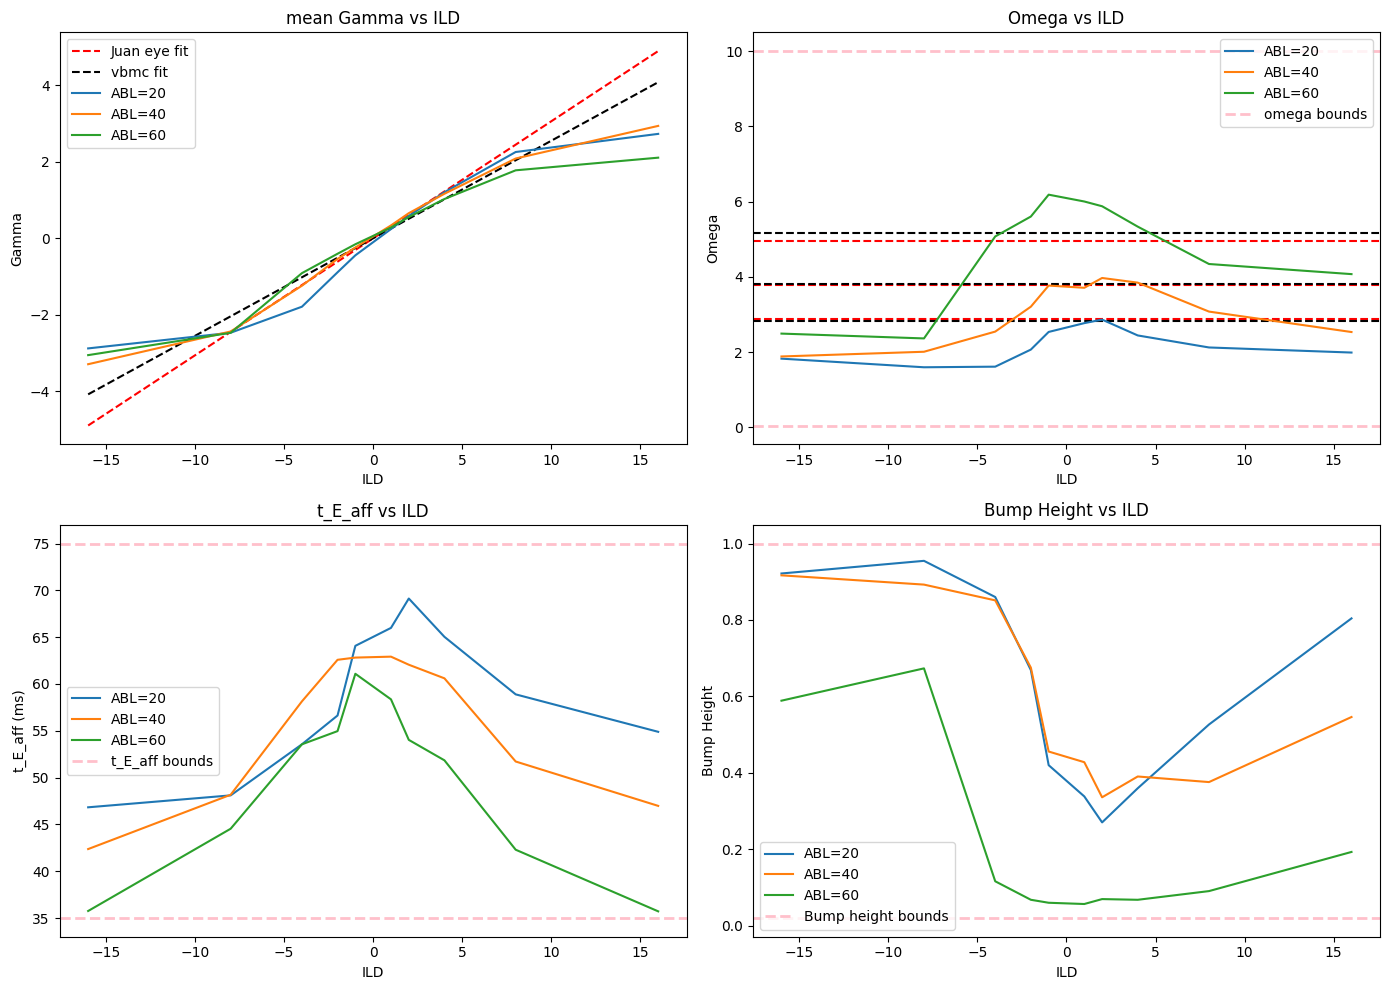

In [7]:
plot_type = 'mean' # mean or median
show_bounds = True

# Define conditions
all_ABL = [20, 40, 60]
all_ILD_sorted = np.sort([1, -1, 2, -2, 4, -4, 8, -8, 16, -16])
n_ABL = len(all_ABL)
n_ILD = len(all_ILD_sorted)

# Initialize arrays for each parameter (8 total)
gamma_vs_ILD = np.zeros((n_ABL, n_ILD))
omega_vs_ILD = np.zeros((n_ABL, n_ILD))
t_E_aff_vs_ILD = np.zeros((n_ABL, n_ILD))
bump_height_vs_ILD = np.zeros((n_ABL, n_ILD))

# Loop over conditions and load samples from each file
for a_idx, abl in enumerate(all_ABL):
    for i_idx, ILD in enumerate(all_ILD_sorted):
        pkl_file = os.path.join('each_cond_data_apr', f"vbmc_T_vary_only_height_single_condn_ABL_{abl}_ILD_{ILD}.pkl")

        with open(pkl_file, 'rb') as f:
            vp = pickle.load(f)
        vp = vp.vp
        vp_samples = vp.sample(int(1e5))[0]
        
        # Compute mean estimates for each parameter
        if plot_type == 'mean':
            gamma_vs_ILD[a_idx, i_idx] = vp_samples[:, 0].mean()
            omega_vs_ILD[a_idx, i_idx] = vp_samples[:, 1].mean()
            t_E_aff_vs_ILD[a_idx, i_idx] = vp_samples[:, 2].mean() * 1000  # in ms
            bump_height_vs_ILD[a_idx, i_idx] = vp_samples[:, 3].mean()
        elif plot_type == 'median':
            gamma_vs_ILD[a_idx, i_idx] = np.median(vp_samples[:, 0])
            omega_vs_ILD[a_idx, i_idx] = np.median(vp_samples[:, 1])
            t_E_aff_vs_ILD[a_idx, i_idx] = np.median(vp_samples[:, 2]) * 1000  # in ms
            bump_height_vs_ILD[a_idx, i_idx] = np.median(vp_samples[:, 3])

# Functions for theoretical predictions (for gamma and omega)
def calc_gamma_vs_ILD(params):
    rate_lambda, T0, theta_E = params
    return rate_lambda * theta_E * all_ILD_sorted / 17.37

def calc_omega_vs_ABL(params, ABL):
    rate_lambda, T0, theta_E = params
    return (2 / (T0 * (theta_E**2))) * (10**(rate_lambda * ABL / 20))

juan_eye_fit_params = [0.118, 1/2220, 45]
vbmc_fit_params = [0.1310, 0.8378e-3, 33.7890]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# ----- Top Row -----

# (0,0) Gamma vs ILD
ax = axs[0, 0]
ax.plot(all_ILD_sorted, calc_gamma_vs_ILD(juan_eye_fit_params), label='Juan eye fit', ls='--', color='r')
ax.plot(all_ILD_sorted, calc_gamma_vs_ILD(vbmc_fit_params), label='vbmc fit', ls='--', color='k')
for a_idx, abl in enumerate(all_ABL):
    ax.plot(all_ILD_sorted, gamma_vs_ILD[a_idx, :], label=f'ABL={abl}')
ax.set_title(f'{plot_type} Gamma vs ILD')
ax.set_xlabel('ILD')
ax.set_ylabel('Gamma')
ax.legend()

# (0,1) Omega vs ILD
ax = axs[0, 1]
for a_idx, abl in enumerate(all_ABL):
    ax.axhline(calc_omega_vs_ABL(juan_eye_fit_params, abl), ls='--', color='r')
    ax.axhline(calc_omega_vs_ABL(vbmc_fit_params, abl), ls='--', color='k')
    ax.plot(all_ILD_sorted, omega_vs_ILD[a_idx, :], label=f'ABL={abl}')
if show_bounds:
    ax.axhline(omega_bounds[0], ls='--', color='pink', lw=2, label='omega bounds')
    ax.axhline(omega_bounds[1], ls='--', color='pink', lw=2)
ax.set_title('Omega vs ILD')
ax.set_xlabel('ILD')
ax.set_ylabel('Omega')
ax.legend()

# ----- Bottom Row -----

# (1,0) t_E_aff vs ILD
ax = axs[1, 0]
for a_idx, abl in enumerate(all_ABL):
    ax.plot(all_ILD_sorted, t_E_aff_vs_ILD[a_idx, :], label=f'ABL={abl}')
if show_bounds:
    ax.axhline(t_E_aff_bounds[0]*1000, ls='--', color='pink', lw=2, label='t_E_aff bounds')
    ax.axhline(t_E_aff_bounds[1]*1000, ls='--', color='pink', lw=2)
ax.set_title('t_E_aff vs ILD')
ax.set_xlabel('ILD')
ax.set_ylabel('t_E_aff (ms)')
ax.legend()

# (1,1) Bump Height vs ILD
ax = axs[1, 1]
for a_idx, abl in enumerate(all_ABL):
    ax.plot(all_ILD_sorted, bump_height_vs_ILD[a_idx, :], label=f'ABL={abl}')
if show_bounds:
    ax.axhline(bump_height_bounds[0], ls='--', color='pink', lw=2, label='Bump height bounds')
    ax.axhline(bump_height_bounds[1], ls='--', color='pink', lw=2)
ax.set_title('Bump Height vs ILD')
ax.set_xlabel('ILD')
ax.set_ylabel('Bump Height')
ax.legend()

plt.tight_layout()
plt.show()


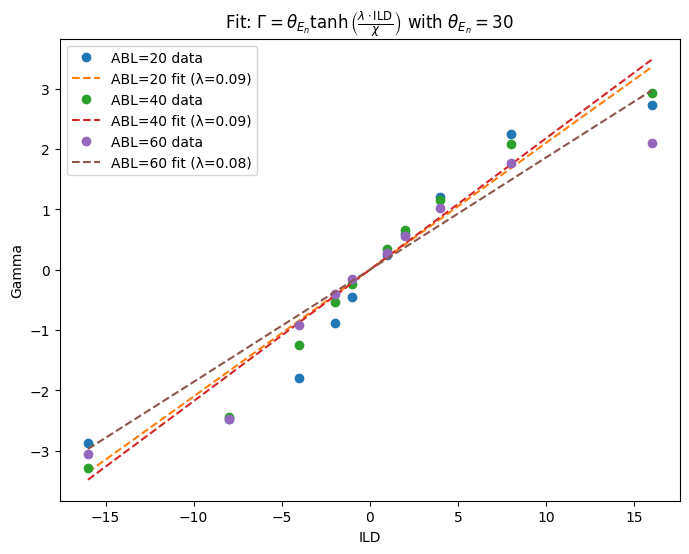

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants
theta_En = 40
chi = 17.37

# Updated model using theta_En * tanh(lambda * ILD / chi)
def gamma_model(ILD, lam):
    return theta_En * np.tanh(lam * ILD / chi)

# Store the fitted lambda values
fitted_lambdas = []

plt.figure(figsize=(8, 6))

for a_idx, abl in enumerate(all_ABL):
    ILD = all_ILD_sorted
    gamma_data = gamma_vs_ILD[a_idx, :]

    # Fit lambda
    popt, _ = curve_fit(gamma_model, ILD, gamma_data, p0=[1.0])
    fitted_lambda = popt[0]
    fitted_lambdas.append(fitted_lambda)

    # Fitted curve
    ILD_smooth = np.linspace(min(ILD), max(ILD), 300)
    gamma_fitted = gamma_model(ILD_smooth, fitted_lambda)

    # Plot original and fit
    plt.plot(ILD, gamma_data, 'o', label=f'ABL={abl} data')
    plt.plot(ILD_smooth, gamma_fitted, '--', label=f'ABL={abl} fit (λ={fitted_lambda:.2f})')

plt.xlabel('ILD')
plt.ylabel('Gamma')
plt.title(r'Fit: $\Gamma = \theta_{E_n} \tanh\left(\frac{\lambda \cdot \text{ILD}}{\chi}\right)$ with $\theta_{E_n}=30$')
plt.legend()


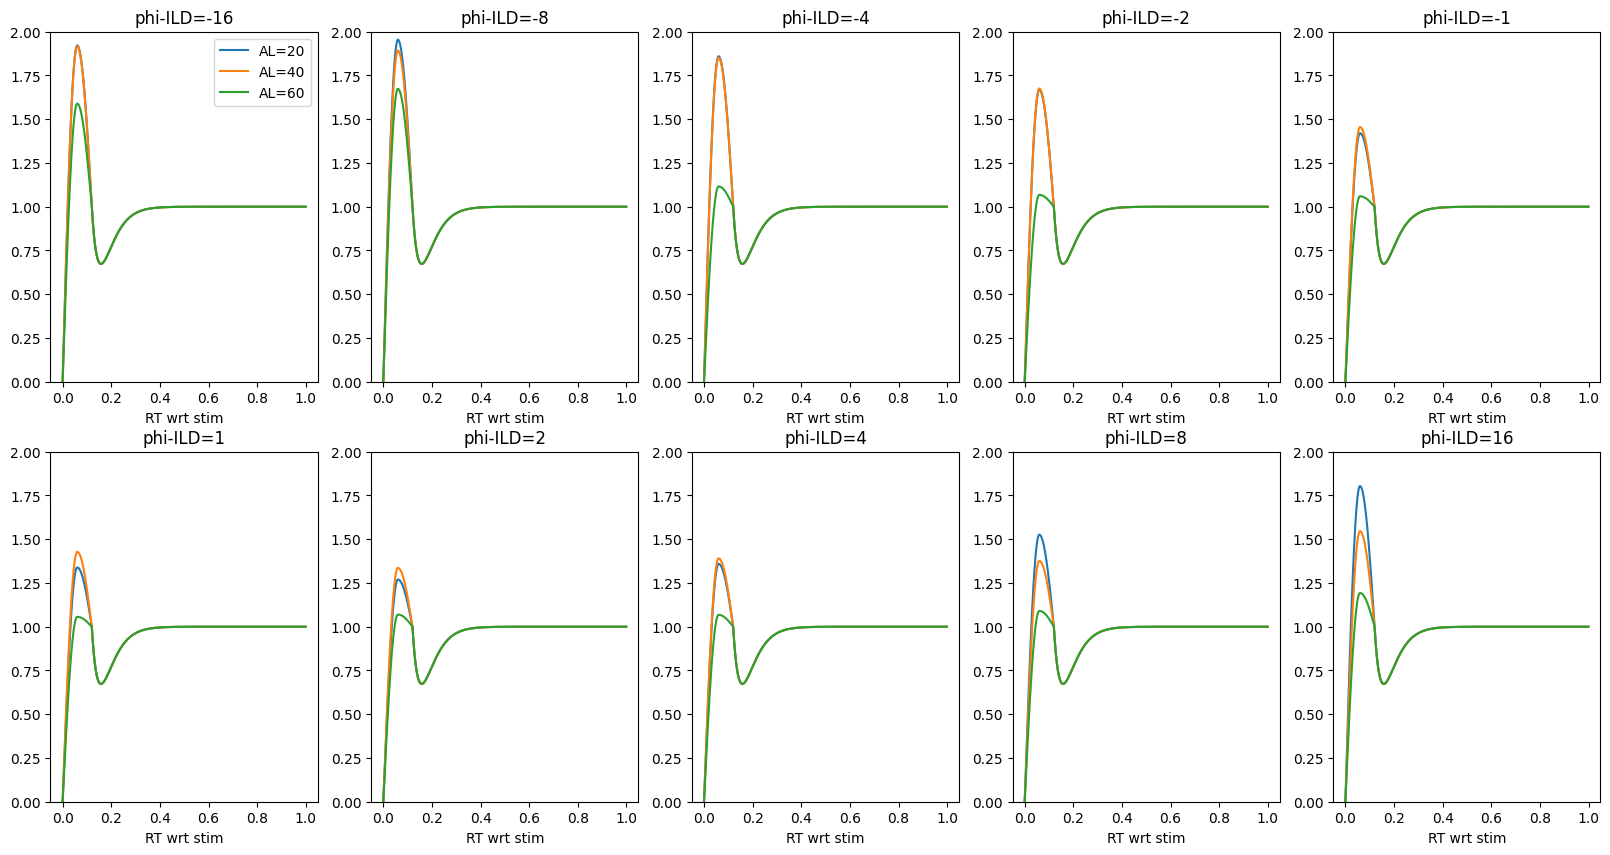

In [13]:
t_pts = np.arange(0, 1, 0.001)
plt.figure(figsize=(20, 10))
fig_num = 1 
for i_idx, ILD in enumerate(all_ILD_sorted):
    
    plt.subplot(2, 5, fig_num)
    for a_idx, ABL in enumerate(all_ABL):
        plt.plot(t_pts, phi_t_fn(t_pts, bump_width, bump_height_vs_ILD[a_idx, i_idx], bump_offset,\
                                                    dip_width, dip_height), label=f'AL={ABL}')
    plt.title(f'phi-ILD={all_ILD_sorted[i_idx]}')
    if i_idx == 0:
        plt.legend()
    plt.xlabel('RT wrt stim')
    plt.ylim(0,2)
    fig_num += 1

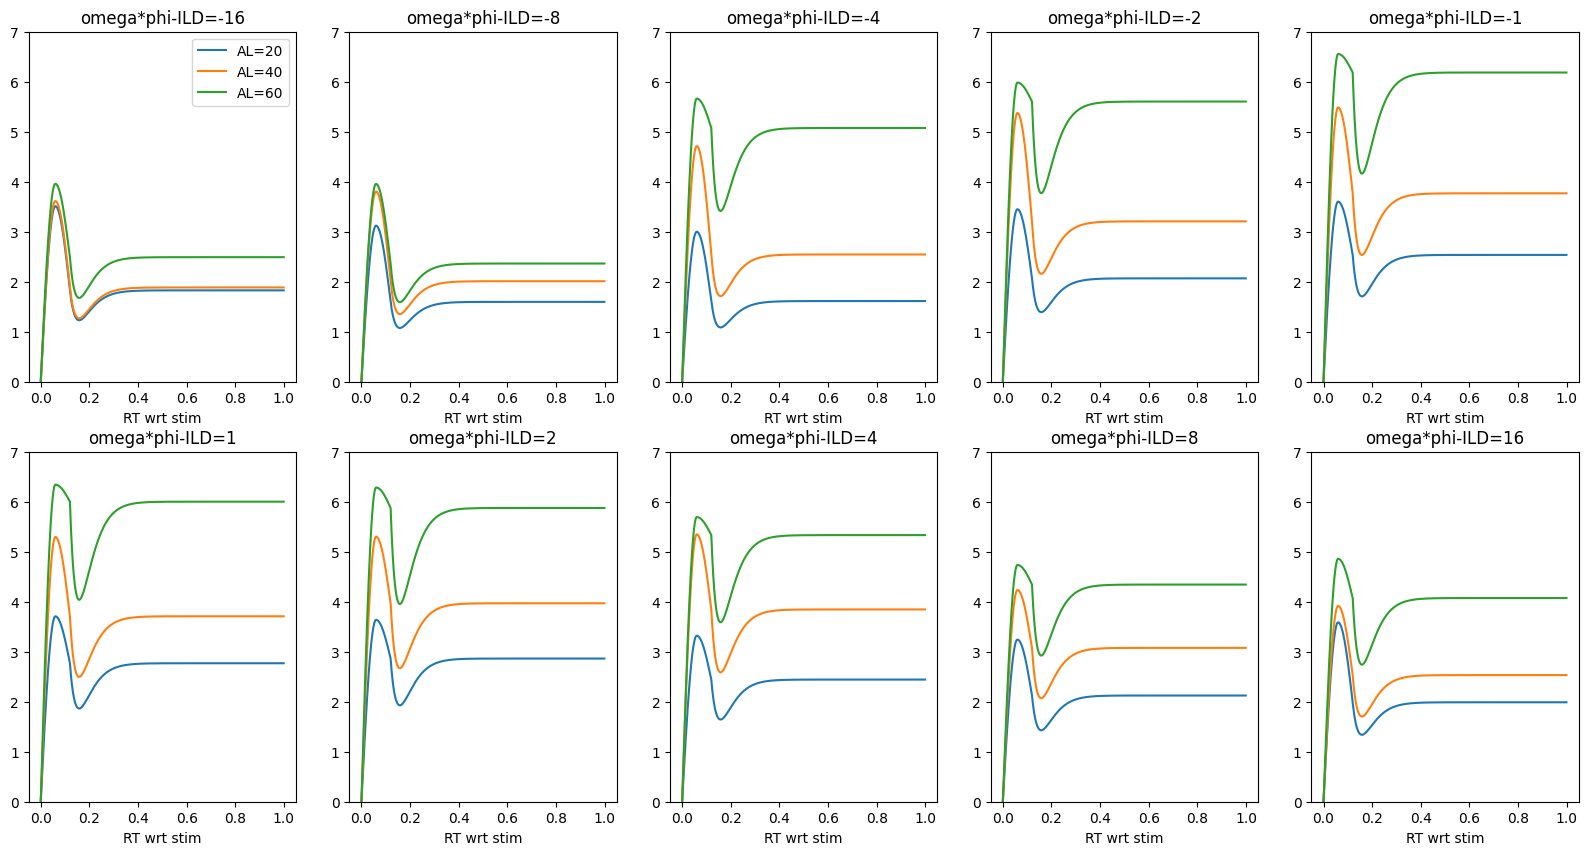

In [14]:
t_pts = np.arange(0, 1, 0.001)
plt.figure(figsize=(20, 10))
fig_num = 1 
for i_idx, ILD in enumerate(all_ILD_sorted):
    
    plt.subplot(2, 5, fig_num)
    for a_idx, ABL in enumerate(all_ABL):
        plt.plot(t_pts, omega_vs_ILD[a_idx, i_idx]*phi_t_fn(t_pts, bump_width, bump_height_vs_ILD[a_idx, i_idx], bump_offset,\
                                                    dip_width, dip_height), label=f'AL={ABL}')
    plt.title(f'omega*phi-ILD={all_ILD_sorted[i_idx]}')
    if i_idx == 0:
        plt.legend()
    plt.xlabel('RT wrt stim')
    plt.ylim(0,7)
    fig_num += 1